# Superstore Sales: Temporal Analysis

## Imports

In [79]:
import warnings
warnings.filterwarnings('ignore')

from helper_funcs import *
from sqlalchemy import create_engine
import numpy as np
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [80]:
# SQLAlchemy Engine
engine = create_engine(generate_url())

## Monthly Analysis

In [81]:
monthly_df = pd.read_sql_table(table_name="monthly_financials", con=engine.connect())
monthly_df.head(10)

,YearMonth,OrderVolume,MonthlySales,DiscountsValueGiven,MonthlyProfit
0,2014-01,79,14236.89,697.96,2450.19
1,2014-02,46,4519.89,191.79,862.31
2,2014-03,157,55691.01,16953.68,498.73
3,2014-04,135,28295.34,3038.66,3488.84
4,2014-05,122,23648.29,4234.37,2738.71
5,2014-06,135,34595.13,4447.32,4976.52
6,2014-07,143,33946.39,5311.25,-841.48
7,2014-08,153,27909.47,3412.60,5318.10
8,2014-09,268,81777.35,14019.81,8328.10
9,2014-10,159,31453.39,4030.99,3448.26


In [82]:
px.line(data_frame=monthly_df, x="YearMonth", y=["MonthlySales", "MonthlyProfit"], title="Time Series for Sales and Profit")

In [83]:
monthly_df.describe()

,OrderVolume,MonthlySales,DiscountsValueGiven,MonthlyProfit
count,48.000000,48.000000,48.000000,48.000000
mean,208.208333,47858.351042,6720.460833,5966.605417
std,104.724148,25195.891228,4127.272053,4288.699326
min,46.000000,4519.890000,191.790000,-3281.010000
25%,139.500000,29790.097500,4068.197500,2939.562500
50%,173.000000,39803.245000,5439.625000,4990.550000
75%,270.500000,65833.345000,9471.542500,8742.505000
max,462.000000,118447.830000,18779.050000,17885.310000


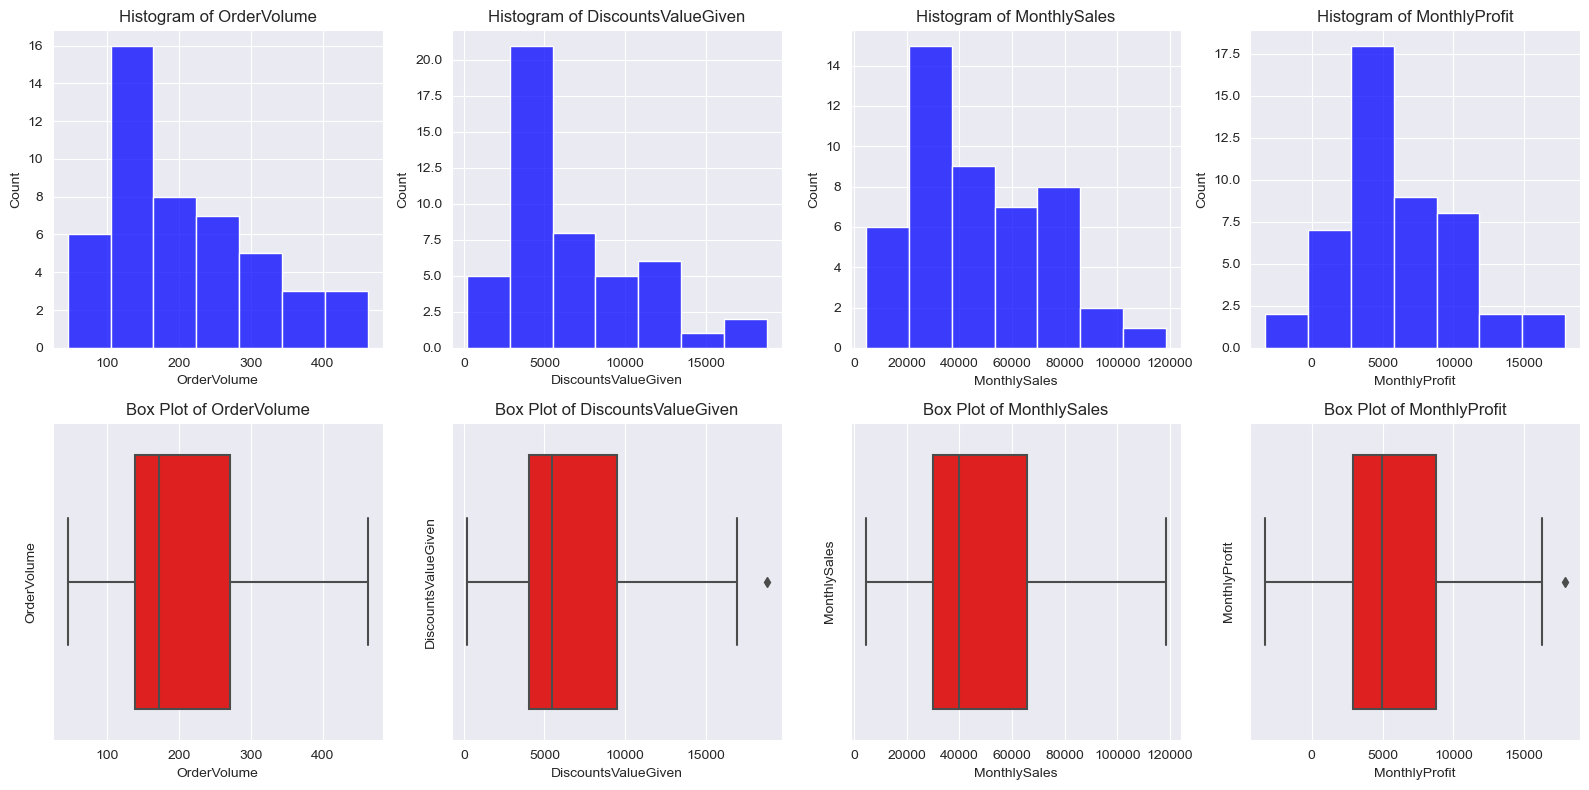

In [84]:
monthly_cols = ['OrderVolume', 'DiscountsValueGiven', 'MonthlySales', 'MonthlyProfit']

# Create 2 x 4 subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Create histograms in the first row
for i, col in enumerate(monthly_cols):
    sns.histplot(monthly_df[col], ax=axes[0, i], color='blue')
    axes[0, i].set_title(f'Histogram of {col}')
    axes[0, i].set_xlabel(col)

# Create box plots in the second row
for i, col in enumerate(monthly_cols):
    sns.boxplot(data=monthly_df, x=col, ax=axes[1, i], color='red')
    axes[1, i].set_title(f'Box Plot of {col}')
    axes[1, i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [85]:
# Shapiro-Wilk test for normality of the variables within monthly_df
print("Normal Variables:")
for label in monthly_cols:
    _, p = st.shapiro(monthly_df[label])
    if p > .05:
        print('\t > {}'.format(label))

Normal Variables:
	 > MonthlySales
	 > MonthlyProfit


## EDA, TSA, and Model Selection
For the purposes of this exercise, we'll be exploring the viability of SARIMAX-like models, but not diving into any form of Deep Learning such as RNNs.

In [86]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [87]:
# Time-series data finagling
ts = monthly_df[['YearMonth', 'MonthlySales']]
ts['YearMonth'] = pd.to_datetime(ts['YearMonth'])
ts.set_index('YearMonth', inplace=True)
ts.head(5)

,MonthlySales
YearMonth,
2014-01-01,14236.89
2014-02-01,4519.89
2014-03-01,55691.01
2014-04-01,28295.34
2014-05-01,23648.29


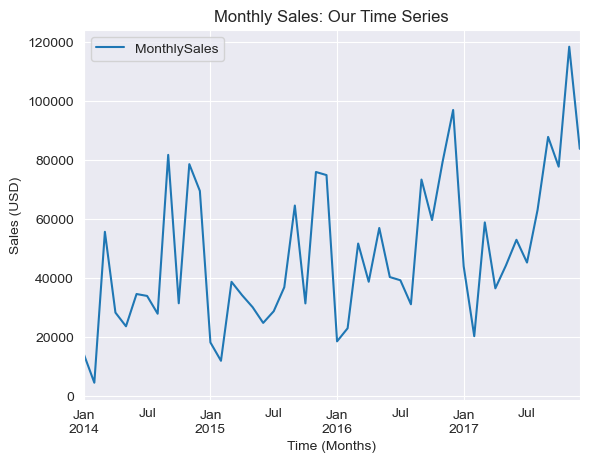

In [88]:
ts.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Sales (USD)')
plt.title("Monthly Sales: Our Time Series")
plt.show()

#### AR & MA parameters

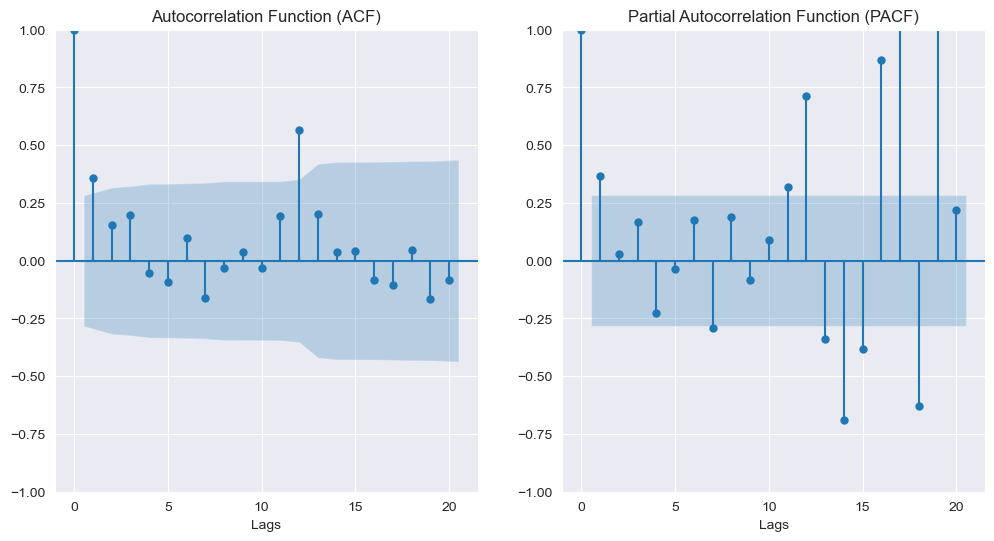

In [89]:
# Plot ACF and PACF for Monthly Sales, side-by-side.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(ts['MonthlySales'], lags=20, ax=plt.gca())
plt.xlabel('Lags')
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(ts['MonthlySales'], lags=20, ax=plt.gca())
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

**REMARKS**:
1. Regarding the ACF plot, points cross our Confidence Region at roughly $1$ and $12$ lags. This would indicate an autoregressive parameter $1 \le p \le 12$.
2. Regarding the PACF plot, points cross our Confidence Region at roughly $1$, next at $12$, but at higher lags, as well. This may indicate the moving average parameter $q \ge 1$.

#### Integration parameter

**QUESTION**: Is our time-series stationary, or does it require an integrated parameter?

*Augmented Dickie-Fuller unit root test*:
* $H_{0}$: The characteristic equation for $Y_{t}$ has a unit root, and is thus, non-stationary.
* $H_{a}$: $Y_{t}$ is stationary, or trend-stationary.

In [90]:
result = adfuller(ts['MonthlySales'].values)
stat, p_val, _, _, crit_val, _ = result

print('ADF Statistic: {:.6f}'.format(stat))
print('p-value: {:.6f}'.format(p_val))
print('Critical Values:')
for key, value in crit_val.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_val <= 0.05:  # You can choose a different significance level
    print("Reject the null hypothesis: The time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is likely non-stationary.")


ADF Statistic: -4.493768
p-value: 0.000202
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
Reject the null hypothesis: The time series is likely stationary.


**REMARK**: Because there is no unit root, the time series $Y_{t}$ of ```MonthlySales``` is either stationary, or trend-stationary. Before model selection, however, we should investigate seasonality and cycling.

#### Decomposition

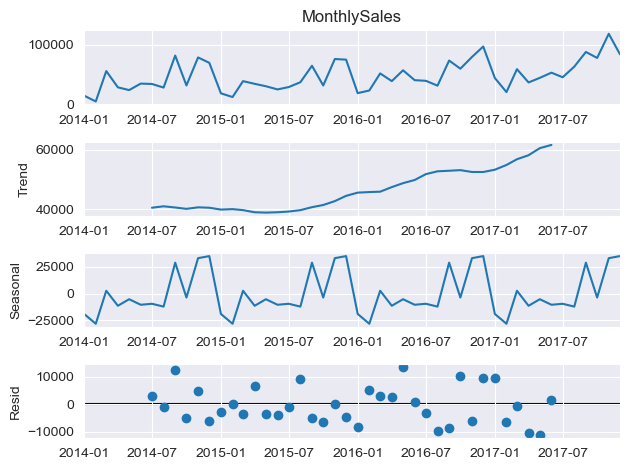

In [91]:
# Decompose and visualize trend, seasonality, and randomness in Monthly Sales.
seasonal_decompose(ts['MonthlySales']).plot()
plt.show()

**REMARKS**:
1. Monthly Sales data is stationary (previously shown), but follows a long-term upward trend.
2. Inspection of the seasonal decomposition reveals annual periodicity, indicating weak or non-seasonality.

## Modeling Process

In [92]:
import pmdarima as pm                           # Compare to RLang's forecast::auto.arima
from statsmodels.tsa.arima.model import ARIMA   # Generalized ARIMA model, including SARIMAX functionality
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [93]:
# Search and select optimal SARIMAX parameters (p,d,q)x(P,D,Q,s) using AIC; use m=12 to indicate monthly aggregates.
prototype = pm.arima.auto_arima(ts['MonthlySales'].values, stationary=True, m=12, start_p=1, max_p=12, start_q=1, max_q=20, max_order=50)
prototype.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [94]:
# Train-Test Split: 80% training, 20% testing
split_index = int(0.8 * len(ts))
train_data, test_data = ts.iloc[:split_index], ts.iloc[split_index:]

In [95]:
test_data

,MonthlySales
YearMonth,
2017-03-01,58872.35
2017-04-01,36521.54
2017-05-01,44261.11
2017-06-01,52981.73
2017-07-01,45264.42
2017-08-01,63120.89
2017-09-01,87866.65
2017-10-01,77776.92
2017-11-01,118447.83


In [96]:
# Build and fit the SARMA model on the training data
model = ARIMA(train_data['MonthlySales'], order=(1, 0, 1), seasonal_order=(1, 0, 0, 12)).fit()


#### Process: $\phi_{1} (B) \Phi_{1} (B^{12}) Y_{t} = \theta_{1} (B) \epsilon_{t} $
**REMARK**: In this model, each observation depends not only on the month prior, but observations made at the same time last year. For example, predictions for March 2017 are likely to be influenced by observations from February 2017, but also from observation from February and March of 2016.

In [97]:
print('AIC: {:.2f}'.format(model.aic))
print('BIC: {:.2f}'.format(model.bic))

AIC: 862.04
BIC: 870.23


In [98]:
# Forecast test data using the trained model
forecast = model.get_forecast(steps=len(test_data))

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

### Model Evaluation

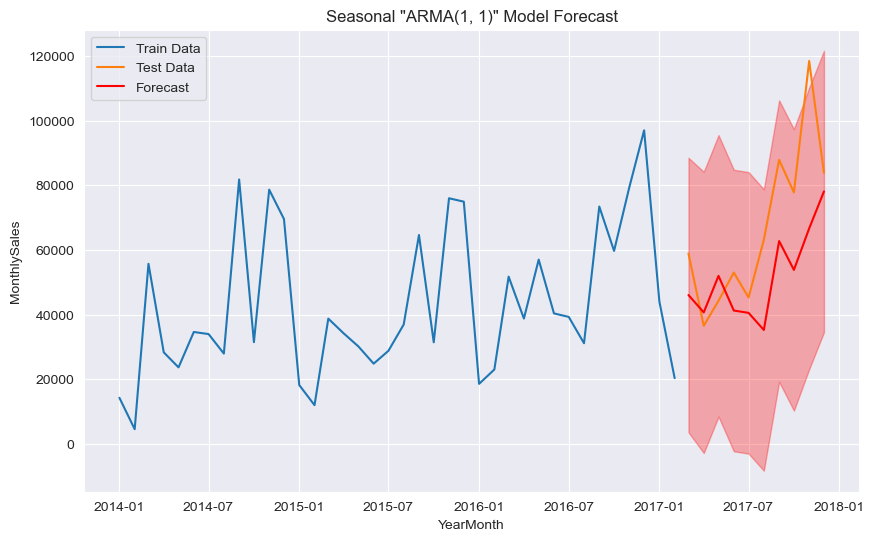

In [104]:
#Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))

plt.plot(train_data.index, train_data['MonthlySales'], label='Train Data')
plt.plot(test_data.index, test_data['MonthlySales'], label='Test Data')
plt.plot(test_data.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test_data.index, confidence_intervals['lower MonthlySales'], confidence_intervals['upper MonthlySales'], color='red', alpha=0.3)

plt.title('Seasonal "ARMA(1, 1)" Model Forecast')
plt.xlabel('YearMonth')
plt.ylabel('MonthlySales')

plt.legend()
plt.show()

[] I say "ARMA(1,1)", because as discussed, there is a seasonal autoregressive (SAR) component of order 1 involved. "SARMA(1, 1, 1)" might've been more appropriate, but would likely lead to confusion as to which seasonal component (SAR vs SMA) is involved.

In [100]:
mae = mean_absolute_error(test_data['MonthlySales'], forecast_values)
mse = mean_squared_error(test_data['MonthlySales'], forecast_values)

print('Mean Absolute Error:     {:,.2f}'.format(mae))
print('Root Mean Squared Error: {:,.2f}'.format(np.sqrt(mse)))

Mean Absolute Error:     17,575.42
Root Mean Squared Error: 22,593.68


**REFLECTION**: While it's true that our "forecast" did successfully capture some of the overall shape of the true test data, there exists some additional lag, and goodness of fit is less than ideal. It may be possible to achieve a better fit by increasing parameter values $p, q$. However, there are at least two problems with this:
1. Increased computational overhead
2. Somewhat more arbitrary selections for $p, q$.

In [101]:
engine.connect().close()